# Neural Network Binary Classification
In this section, I will be using a Deep Learning binary classification model using the following datasets to see the effects of PCA and Normalization on the dataset for accuracy:
1. Regular Dataset - The raw, non-normalized features
2. Normalized Dataset - The nomralized features
3. PCA Dataset - From using SVD during PCA, is the Ur Matrix
4. PCA Reduced Dataset - The PCA Dataset containing only the first three columns, which accounted for nearly 100% of the variance

In [1]:
# get datasets
import pandas as pd
import numpy as np
labels = pd.read_csv('VSA_labels.csv')
x_norm = pd.read_csv('VSA_new_norm.csv')
x_norm_re = pd.read_csv('VSA_norm_reduced.csv')
x_tot = pd.read_csv('VSA_new_total.csv')
x_ur = pd.read_csv('VSA_ur.csv')
x_ur_re = pd.read_csv('VSA_ur_reduced.csv')

# convert them all into np arrays
labels = labels.values
x_tot = x_tot.values
x_norm = x_norm.values
x_norm_re = x_norm_re.values
x_ur = x_ur.values
x_ur_re = x_ur_re.values

## Splitting the Dataset
In order to train a dataset, one should split the dataset into training and testing sets. This is because if the entire set is used as the training set, then there is no way to test to see if the network classification reflects the nature of the data, or the nature of the observations.

A good rule of thumb is the 70 15 15 rule, or splitting the dataset into 70% training, 15% testing, and 15% validation sets. I specify the validation set when training later on.

In [2]:
# Split the data into train and test sets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# order of the keys:  x_train, x_test, y_train, y_test
xy_dict = {}
xy_dict['Regular Dataset'] = train_test_split(x_tot, labels, test_size=0.15)
xy_dict['Normalized Dataset'] = train_test_split(x_norm, labels, test_size=0.15)
xy_dict['Normalized Reduced Dataset'] = train_test_split(x_norm, labels, test_size=0.15)
xy_dict['PCA Dataset'] = train_test_split(x_ur, labels, test_size=0.15)
xy_dict['PCA Reduced Dataset'] = train_test_split(x_ur_re, labels, test_size=0.15)

## Choosing Parameters for the Model
Since this prolem is a binary classification model which splits plans into good versus bad plans. The sigmoid function is the output activation because it locks the outputs within the range of 0 and 1. Because the dataset is relatively small, the optimizer I am using is Stochastic Gradient Descent. The best metric for any classification model is accuracy, and for a binary classifier, the best loss function is binary cross-entropy.

I found that the models mostly converged by 10 epochs, and that 64 is a good enough batch size.

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import auc
#-------------------------functions---------------------
# Builds a model with 64 hidden units for binary classification
# Returns the model
def build_model():
    model = Sequential([
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'],
        verbose=0)
    return model

# for the ROC metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Takes in a Keras model and returns the ROC metrics, AUC
# Returns the FPR, TPR, and AUC
def get_roc_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_ = auc(fpr, tpr)
    return (fpr, tpr, auc_)

#-------------------------------------------------------

# stores the ROC metrics for each dataset
model_dict = {}
# stores accuracy history
history_dict = {}

# some hyperparameters
model_no_epochs = 10
model_batch_size = 64

# get the ROC metrics for each dataset
for key in xy_dict:
    (x_train, x_test, y_train, y_test) = xy_dict[key]
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.18, 
                epochs=model_no_epochs, batch_size=model_batch_size)
    # store history
    history_dict[key] = history
    # store ROC metrics
    fpr, tpr, auc_ = get_roc_metrics(model, x_test, y_test)
    model_dict[key] = [fpr, tpr, auc_]

F:\kayfolder\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 1707 samples, validate on 375 samples
Epoch 1/10
1707/1707 [==============================] - 2s 967us/step - loss: 7.7377 - acc: 0.5073 - val_loss: 8.4526 - val_acc: 0.4667
Epoch 2/10
1707/1707 [==============================] - 0s 44us/step - loss: 7.8665 - acc: 0.5062 - val_loss: 8.4356 - val_acc: 0.4667
Epoch 3/10
1707/1707 [==============================] - 0s 43us/step - loss: 7.8529 - acc: 0.5062 - val_loss: 8.4203 - val_acc: 0.4720
Epoch 4/10
1707/1707 [==============================] - 0s 40us/step - loss: 7.8203 - acc: 0.5067 - val_loss: 8.4204 - val_acc: 0.4693
Epoch 5/10
1707/1707 [==============================] - 0s 45us/step - loss: 7.7933 - acc: 0.5073 - val_loss: 8.4198 - val_acc: 0.4693
Epoch 6/10
1707/1707 [==============================] - 0s 43us/step - loss: 7.8010 - acc: 0.5026 - val_loss: 8.4236 - val_acc: 0.4693
Epoch 7/10
1707/1707 [==============================] - 0s 41us/step - loss: 7.7969 - acc: 0.5067 - val_loss: 8.4309 - val_acc: 0.4693
Epoch 8

## Training vs Testing Accuracy
By observing the accuracy of the training versus the validation sets, one can make sure that the model is not overfitting to the training set's data. If the accuracy decreases (classification error rate increases) for the validation set while the training set stays the same, it is a sign that the model has overfitted.

When after a certain number of epochs, the accuracy does not seem to increase, the model is said to have "converged". The faster a model converges (less number of epochs to become stable), the less resource intensive it is, which is extremely important when dealing with Machine Learning.

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

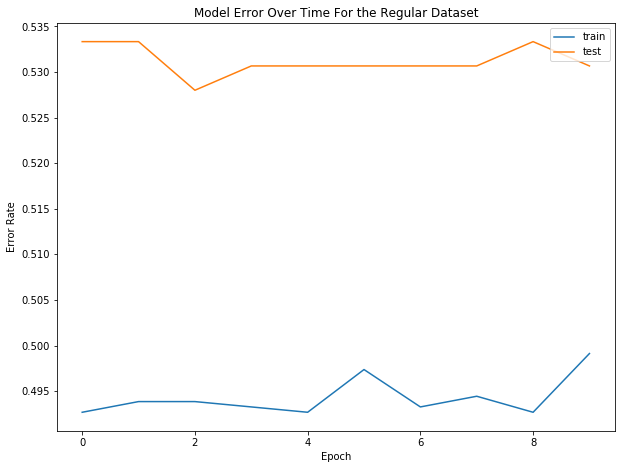

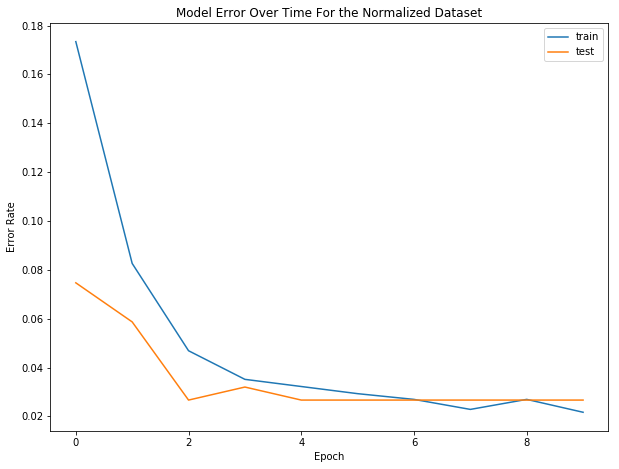

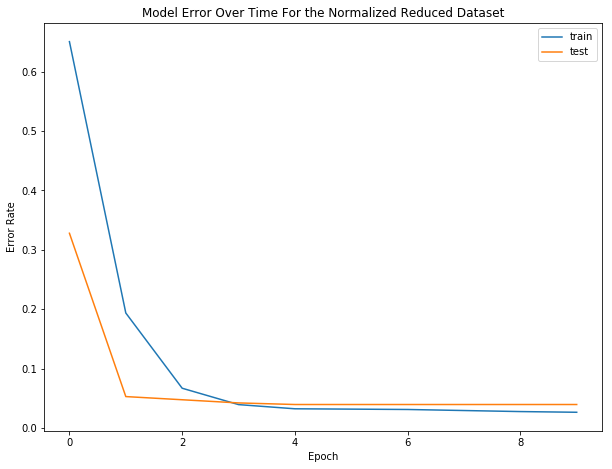

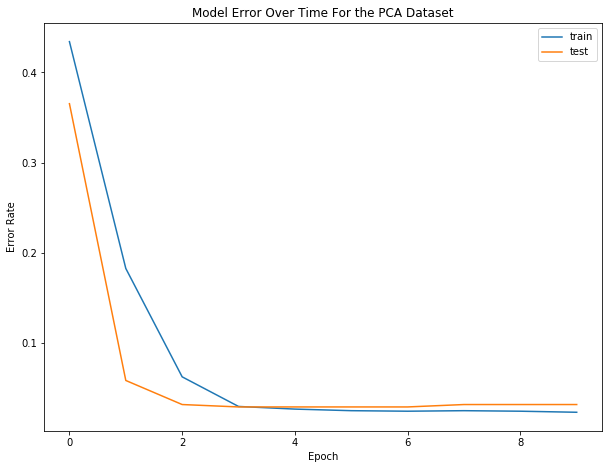

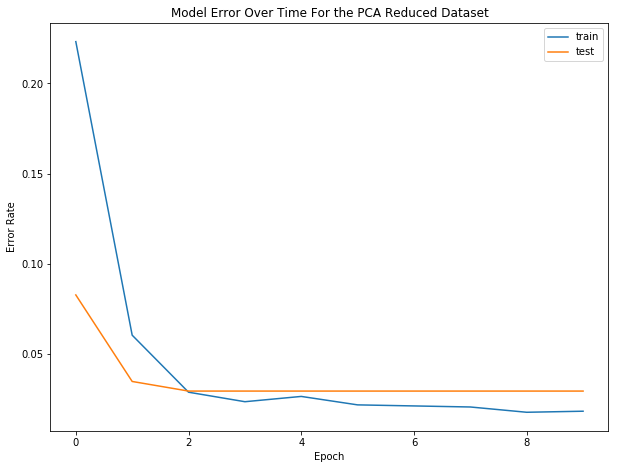

In [7]:
# code guide: machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# for plotting
import matplotlib
import matplotlib.pyplot as plt

# make error plots for each
for key in history_dict:
    plt.figure(1, figsize=(10,7.5))
    # summarize history for loss
    his = history_dict[key]
    error_rate = his.history['acc']
    for i in range(len(error_rate)):
        error_rate[i] = 1 - error_rate[i]
    plt.plot(error_rate)
    val_error_rate = his.history['val_acc']
    for i in range(len(val_error_rate)):
        val_error_rate[i] = 1 - val_error_rate[i]
    plt.plot(val_error_rate)
    plt.title('Model Error Over Time For the ' + key)
    plt.ylabel('Error Rate')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

The above graphs show that the training versus testing error for for each of the four datasets. The Noramlized, PCA, and PCA reduced datasets converge in around 5 epochs. Each have an error rate hovering just under 0.05. 

Meanwhile, the Regular dataset has a validation accuracy of around 0.4, and a training accuracy around 0.5. This means that the Regular dataset model actually does *worse* than random guessing.

## Reciever Operating Characteristic (ROC) Curves
A binary classifier may classify an obseration as positive or negative. ROC curves are created by plotting the true positive rate (TPR) and false positive rate (FPR) of the classifier at different thresholds. Depending on the threshold, increasing the TPR may come with increasing the FPR by categorizing too many inputs as positive. The accuracy of a test then depends on the area under the curve (AUC), a value between 0 and 1 where maximum accuracy is 1, and minimum accuracy is 0. The higher the value of the AUC, the better the classifier.

Below, I compare the AUC from training models using the various datasets.

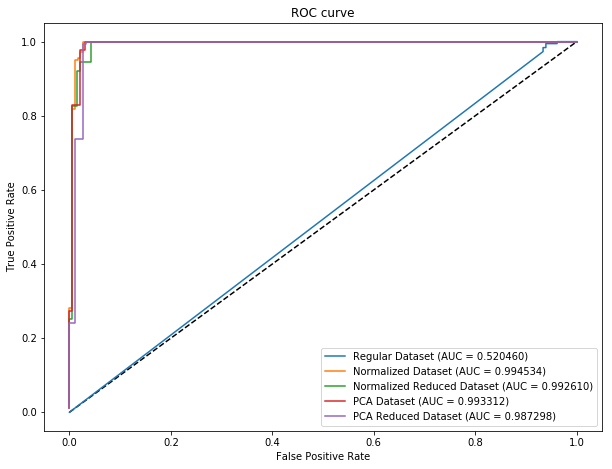

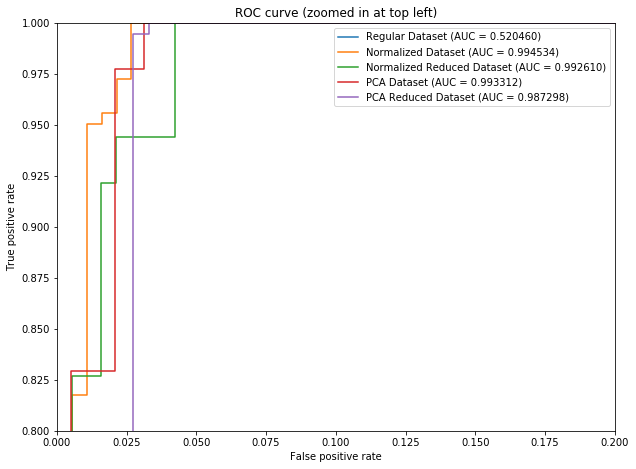

In [8]:
# plot the curves normal size
plt.figure(1, figsize=(10,7.5))
plt.plot([0, 1], [0, 1], 'k--')
for key in model_dict.keys():
    (fpr, tpr, auc_) = model_dict[key]
    plt.plot(fpr, tpr, label=key + ' (AUC = %3f)' % auc_)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#plot the curves close up
plt.figure(2, figsize=(10,7.5))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
for key in model_dict.keys():
    (fpr, tpr, auc_) = model_dict[key]
    plt.plot(fpr, tpr, label=key + ' (AUC = %3f)' % auc_)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

The graphs above show that after 10 epoches, the majority of the datasets have very similar accuracies. Running the models a couple times finds that while the values vary, the Normalized, Normalized Reduced, the PCA, and PCA reduced datasets have very similar accuracies.

This shows that PCA and dimensionality reduction can be just as accurate as having more variables, while being much less computationally expensive. The Normalized Reduced has only two features, while the PCA reduced has only three features, a fraction compared to the 8 features of the other datasets.

The results of this also shows the importance of data normalization. Using a dataset that is not normalized is around as accurate as using random classifier.

## Conclusion
The best dataset to use was the PCA Reduced Dataset. This may be because having fewer features allows for greater generalization while cutting down the number of input variables. Next best is the PCA dataset, where the the variables have been transformed into orthogonal components, giving a more precise classification boundary. However, the normalized features also produce very accurate results, statistically identical to the PCA and PCA Reduced datasets.

Finally, do not used data that is not normalized. When it came to validation, the classifier did worse than random guessing.